In [ ]:
import pickle
allCommentary = pickle.load(open('allCommentary', 'rb'))
allNews = pickle.load(open('allNews', 'rb'))

In [118]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer


In [407]:
from corpus_toolkit import corpus_tools as ct

In [3]:
#The isUSA and isME columns will tell if the articles are about the US or Middle East (by searching tags)
#Adding these columns to both types of articles
allCommentary['isUSA'] = allCommentary["Tags"].str.contains('United States')
allCommentary['isME'] = allCommentary["Tags"].str.contains('Middle East')
allNews['isUSA'] = allNews["Tags"].str.contains('United States')
allNews['isME'] = allNews["Tags"].str.contains('Middle East')

In [4]:
usCommentary = allCommentary.loc[allCommentary["isUSA"] == True]
notUSCommentary = allCommentary.loc[allCommentary["isUSA"] == False]
meCommentary = allCommentary.loc[allCommentary["isME"] == True]
notMECommentary = allCommentary.loc[allCommentary["isME"] == False]

In [427]:
#This is supposed to tell the most frequent words in each subcorpus
corp1freq = ct.frequency(ct.tokenize(' '.join(notUSCommentary["Processed"]).lower()))
corp2freq = ct.frequency(ct.tokenize(' '.join(usCommentary["Processed"]).lower()))
corp_key = ct.keyness(corp1freq,corp2freq, effect = "log-ratio")

In [428]:
#For some reason, it displays weird characters, and I wasn't able to find a solution
ct.head(corp_key, hits = 10) #to display top hits


&	33.39180416696846
§	32.26527176103953
 	32.178560127846204
ç	31.606308678874598
ã	31.528306166873325
…	31.31257747581789
á	31.002237355205736
š	31.002237355205736
•	30.64378338429326
í	30.44584400668135


In [2]:
import pickle
allCommentary = pickle.load(open('allCommentary', 'rb'))
allNews = pickle.load(open('allNews', 'rb'))

In [59]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imadrizvi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
#Function to remove stopwords, tokenize, and lemmatize
def tokenLemmatize(meText):
    meText = meText.lower()
    #Remove non-alphanumeric 
    meText = re.sub("[^A-Za-z']+", ' ', meText)
    
    #Remove stopwords and tokenize
    
    stop_words = set(stopwords.words('english')) 

    word_tokens = word_tokenize(meText) 
    meText = [w for w in word_tokens if not w in stop_words] 

    #Lemmatize
    lemmatizer = WordNetLemmatizer() 
    meText = list(map(lemmatizer.lemmatize, meText))
    
    return(meText)

In [63]:
#All the Middle East-related text
meText = ' '.join(meCommentary['Processed'])
meText = tokenLemmatize(meText)
notMEText = ' '.join(notMECommentary['Processed'])
notMEText = tokenLemmatize(notMEText)



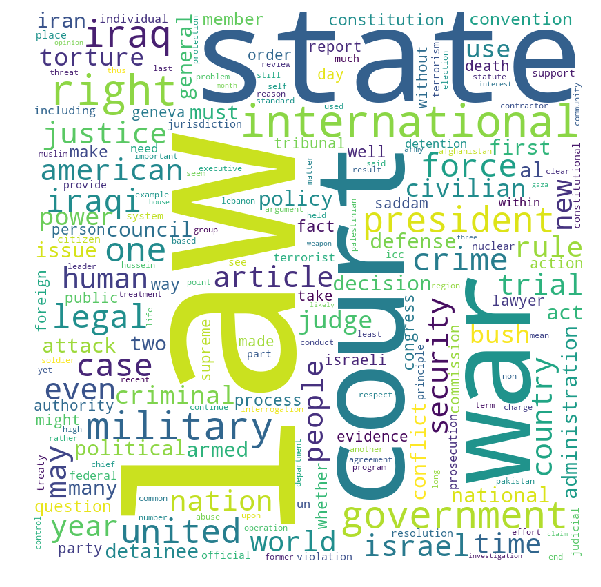

In [62]:
#Generate Wordcloud for Middle East Commentary Articles
from wordcloud import WordCloud, STOPWORDS 
from matplotlib import pyplot as plt
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                collocations = False,
                min_font_size = 10).generate(' '.join(meText)) 
  
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
#As before, we see the generic words that tend to be in every article, we need to adjust for weight

In [64]:
#Chi Square Test followed on this link: https://www.coursera.org/lecture/big-data-language-2/keyness-of-word-P1VpG
#In order to generate words that are more significant in ME-related articles, 
#we will sort based on chisquare test statistic value

from collections import Counter
#A dictionary of how often each word appears
meWordAppearance = dict(Counter(meText))
notMEWordAppearance = dict(Counter(notMEText))


In [69]:
#Get the Union of the two lists
def Union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2)) 
    return final_list 
  

In [71]:
#Find union of lists using above function
allWords = Union(list(meWordAppearance.keys()),list(notMEWordAppearance.keys()))

In [75]:
import pandas as pd
wordFreq = pd.DataFrame({'word': allWords})

In [77]:
#Make a dataframe that shows how frequent each word is in middle east and non-middle east articles
wordFreq['ME'] = wordFreq['word'].apply(lambda x: meWordAppearance.get(x))
wordFreq['notME'] = wordFreq['word'].apply(lambda x: notMEWordAppearance.get(x))


In [83]:
#we will only handle words that appear in both Middle East and non Middle East articles for chi square statistic
commonWordFreq = wordFreq.dropna()

In [84]:
#THere are 207k words in the Middle East(ME) articles and 1.9M words in the non-ME articles
print(len(meText))
print(len(notMEText))

207832
1933620


In [88]:
commonWordFreq['expectedRate'] = commonWordFreq['ME'] + commonWordFreq['notME']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [89]:
commonWordFreq['expectedRate'] = commonWordFreq['expectedRate'] / (len(meText)+len(notMEText))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
commonWordFreq['expectedME'] = commonWordFreq['expectedRate'] * len(meText)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
commonWordFreq['expectedNotME'] = commonWordFreq['expectedRate'] * len(notMEText)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [112]:
commonWordFreq['otherME'] = len(meText) - commonWordFreq['ME'] 
commonWordFreq['otherNotME'] = len(notMEText) - commonWordFreq['ME'] 

commonWordFreq['expectedOtherME'] = len(meText) * (1-commonWordFreq['expectedRate'])
commonWordFreq['expectedOtherNotME'] = len(notMEText) * (1-commonWordFreq['expectedRate'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [116]:
#Calculate the test statistic
#The above columns were made to make this step easier
commonWordFreq['chisq'] = (commonWordFreq['ME'] - commonWordFreq['expectedME'])**2 / (commonWordFreq['expectedME']) + (commonWordFreq['notME'] - commonWordFreq['expectedNotME'])**2 / (commonWordFreq['expectedNotME']) + ((commonWordFreq['otherME'] - commonWordFreq['expectedOtherME'])**2 / (commonWordFreq['expectedOtherME'])) + ((commonWordFreq['otherNotME'] - commonWordFreq['expectedOtherNotME'])**2 / (commonWordFreq['expectedOtherNotME']))
 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
#Here is a sorted by chi square value look at the most and least frequent words
#Unsurprisingly, the words that appear more disproportionately in articles about the Middle East are geography related
#But also interesting that "war", "contractor", "bush", and "force" appear disproportionately more
commonWordFreq.sort_values('chisq', ascending=False)

,word,ME,notME,expected,expectedRate,expectedME,expectedNotME,chisq,otherME,otherNotME,expectedOtherME,expectedOtherNotME
11435,iraq,879.0,664.0,1543.0,0.000721,149.751092,1393.248908,3935.650836,206953.0,1932741.0,207682.248908,1.932227e+06
33185,iraqi,633.0,368.0,1001.0,0.000467,97.148959,903.851041,3274.730825,207199.0,1932987.0,207734.851041,1.932716e+06
31687,saddam,286.0,82.0,368.0,0.000172,35.715102,332.284898,1942.773889,207546.0,1933334.0,207796.284898,1.933288e+06
43194,war,1247.0,3077.0,4324.0,0.002019,419.652445,3904.347555,1813.399101,206585.0,1932373.0,207412.347555,1.929716e+06
26018,israel,559.0,730.0,1289.0,0.000602,125.099908,1163.900092,1667.804492,207273.0,1933061.0,207706.900092,1.932456e+06
34612,hussein,167.0,52.0,219.0,0.000102,21.254368,197.745632,1106.930676,207665.0,1933453.0,207810.745632,1.933422e+06
22382,hezbollah,146.0,27.0,173.0,0.000081,16.789980,156.210020,1101.313923,207686.0,1933474.0,207815.210020,1.933464e+06
28394,iran,383.0,582.0,965.0,0.000451,93.655090,871.344910,990.531705,207449.0,1933237.0,207738.344910,1.932749e+06
32490,contractor,173.0,83.0,256.0,0.000120,24.845288,231.154712,978.524653,207659.0,1933447.0,207807.154712,1.933389e+06
13499,lebanon,160.0,93.0,253.0,0.000118,24.554132,228.445868,827.545238,207672.0,1933460.0,207807.445868,1.933392e+06


In [ ]:
#Another possible direction woudl be to try maximum likelihood instead